This notebook is where the ranking curves are generated. Make changes to the "params" dictionary to properly run this notebook for generating ranking curves. The params dictionary is described as follows:

- target_board: The target board name. choices = {"XMEGA", "STM32F"}
- aes_type: The type of board and aes, # choices = {"xmega-masked", "xmega-unmasked", "stm32f-unmasked"}
- input_path: path to the testing dataset. This could be the directory containing the file or the path to the file itself.
- target_byte: The byte for which ranking is to be performed
- start_idx: The start index of the attack window
- end_idx: The end index of the attack window
- testType: If you want to load dataset with different key from testing. Mostly it is "samekey" # choices={'samekey', 'diffkey'}
- n: Number of traces to be used for generating the ranking curve
- sets: Divide the 256 traces into eqal sets
- ranking_curve_path: path where the ranking information is saved from Step 3

In [1]:
import os, sys
# setting the utilities required for loading the data and training the model
# parent_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..')) + '/utilities/'
sys.path.append('../utilities/')

from graphGenerationUtilities import *

import warnings
warnings.filterwarnings('ignore')

# %matplotlib nbagg
%load_ext autotime

In [2]:
# parameters for loading the dataset for testing k-NN
params = {
    "target_board": "STM32F", # choices = {'XMEGA', 'STM32F'}
    "aes_type": "stm32f-unmasked", # choices = {"xmega-masked", "xmega-unmasked", "stm32f-unmasked"}
    "input_path": '../../TripletPower-data/stm32f-unmasked/train-test-256-k-nn/PC2_CB2_TDS3_K6_U_20k/test_same_key.npz',  # path to load the dataset
    "target_byte": 2,  # byte for which ranking is to be performed
    "start_idx": 1200,
    "end_idx": 2200,
    "testType": "samekey",  # choices={'samekey', 'diffkey'}
    "n": 10000, # number of traces to be used for testing
    "sets": 8, # divide the 256 traces into eqal sets
    "ranking_curve_path": '../results/unmasked-aes-stm32f/ranks-accuracy-n-2500/', # path to save key ranking curve
}

In [3]:
x_test, y_test, test_data_df, nb_classes_test, test_plain_text, key = load_data(params,
                                                                                     data_label="test")

parameters of the dataset are:  {'target_board': 'STM32F', 'aes_type': 'stm32f-unmasked', 'input_path': '../../TripletPower-data/stm32f-unmasked/train-test-256-k-nn/PC2_CB2_TDS3_K6_U_20k/test_same_key.npz', 'target_byte': 2, 'start_idx': 1200, 'end_idx': 2200, 'testType': 'samekey', 'n': 10000, 'sets': 8, 'ranking_curve_path': '../results/unmasked-aes-stm32f/ranks-accuracy-n-2500/'}
loading the test data ...
test_data_path:  ../../TripletPower-data/stm32f-unmasked/train-test-256-k-nn/PC2_CB2_TDS3_K6_U_20k/test_same_key.npz
test data loaded successfully!
reshaped traces for the feature extractor: (20000, 1000, 1)
shape of the labels: (20000,)
shape of X_profiling:  (20000, 1000)
shape of y_profiling:  (20000,)
number of classes in the dataset:  256
Test key:  [198  91  97  57 152  71 214 101 138  74  78  84  27 234  87  22]


In [4]:
# read the CSV file containing accuracies
acc_path = os.path.join(params['ranking_curve_path'], '256-knn-accuracies.csv')
acc = pd.read_csv(acc_path)
acc.head()

,model-name,accuracy
0,knn-key-value-0.model,0.0009
1,knn-key-value-1.model,0.0060
2,knn-key-value-2.model,0.0000
3,knn-key-value-3.model,0.0012
4,knn-key-value-4.model,0.0013


In [5]:
# get the accuracy of the k-nn model
search_acc = 'knn-key-value-' + str(key[params['target_byte']]) + '.model'
search_result = acc.loc[acc['model-name'].str.contains(search_acc, case=False)]

In [6]:
%%capture cap --no-stderr
model_name = search_result['model-name'].values[0].split('.')[0].split('-')[-1]
print('Model name is: ', model_name)
model_accuracy = search_result['accuracy'].values[0]
print('Accuracy is: ', model_accuracy)

In [7]:
acc_txt_path = os.path.join(params['ranking_curve_path'], 'accuracy.txt')
with open(acc_txt_path, 'w') as f:
    f.write(cap.stdout)
    
print('Correct key guess model and its accuracy is saved to %s.'%(acc_txt_path))

Correct key guess model and its accuracy is saved to ../results/unmasked-aes-stm32f/ranks-accuracy-n-2500/accuracy.txt.


#### Generating Accuracy Plot

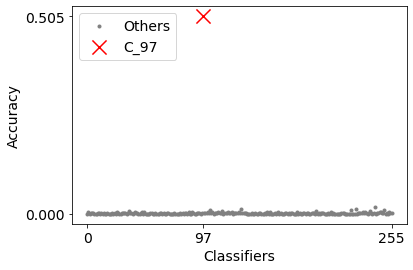

In [8]:
sizes = np.array([200])
model_idxs = np.arange(0, 256, 1)
fig, ax = plt.subplots()
for i in range(len(acc)):
    if i == key[params['target_byte']]:
        plt.scatter(i, acc['accuracy'][i], color='r', marker='x', s=sizes, label='C_'+str(key[params['target_byte']]))
    else:
        plt.scatter(i, acc['accuracy'][i], marker='.', color='grey', label='Others')
legend_without_duplicate_labels(ax, loc="upper left")
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.xticks([0, 255, key[params['target_byte']]])
from matplotlib.ticker import StrMethodFormatter
                             
if params['target_board'] == 'STM32F':
    plt.yticks([0, round(max(acc['accuracy']), 3)])
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}')) # 2 decimal places
else:
    plt.yticks([0, 1])
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
path_str = params['aes_type'] + '-target-byte-' + str(params['target_byte']) + '-accuracy.png'
acc_plot_path = os.path.join(params['ranking_curve_path'], path_str)
plt.savefig(acc_plot_path, dpi=150, bbox_inches='tight')
plt.show()

#### Generating Ranking Curves Plots

In [9]:
for i in range(0, 256, 32):
    print('processing set %d - %d ...'%(i, i+32))
    temp_acc = acc.iloc[i:i+32, :]
    temp_save_path = params['ranking_curve_path'] + params["aes_type"] + '-target-byte-' + str(params['target_byte']) + '-' + str(i) + '-' + str(i+31) +'-' + str(params["n"]) + '-traces.png'
    generate_ranking_plot(params, key, temp_acc, index_range=[i, i+32], save_path=temp_save_path)
    print('processing completed from %d - %d.'%(i, i+32))

processing set 0 - 32 ...
generating a plot for STM32F target board...
plot for STM32F target board saved successfully.
processing completed from 0 - 32.
processing set 32 - 64 ...
generating a plot for STM32F target board...
plot for STM32F target board saved successfully.
processing completed from 32 - 64.
processing set 64 - 96 ...
generating a plot for STM32F target board...
plot for STM32F target board saved successfully.
processing completed from 64 - 96.
processing set 96 - 128 ...
generating a plot for STM32F target board...
plot for STM32F target board saved successfully.
processing completed from 96 - 128.
processing set 128 - 160 ...
generating a plot for STM32F target board...
plot for STM32F target board saved successfully.
processing completed from 128 - 160.
processing set 160 - 192 ...
generating a plot for STM32F target board...
plot for STM32F target board saved successfully.
processing completed from 160 - 192.
processing set 192 - 224 ...
generating a plot for STM32